# Курсовая работа
1. [Сборка датасета](#dataset_collect)
    1. [Коллокации](#collocations_collect) (для оценки качества)
    2. [Документы](#documents_collect)
2. [SyntaxNet](#syntaxnet)
    1. [Запуск SyntaxNet](#syntaxnet_run)
    2. [Обработка результатов SyntaxNet'а](#syntaxnet_postprocess)
    
    #### To be done...
3. [TopMine](#topmine)
4. Запуск тематической модели
5. Обучение итоговой модели

In [4]:
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem

import ngrammer

from bs4 import BeautifulSoup
import re

import pandas as pd
import csv

import json
import os
import time

In [109]:
WIKI_XML = "../wiki.xml"
WIKIEXTRACTOR_FOLDER = "../wikiextractor/"
WIKITEXTS_JSON_FOLDER = "../wikitexts_json/"

WIKI_COLLECTION = "../collection/"
COLLOCS_FILE = "../collocs.txt"

SYNTAXNET_INPUT = "../sentences.txt"
SYNTAXNET_OUTPUT = "../syntaxnet_out.txt"

LEMMATIZED_COLLECTION = "../lemmatized_collection/"
STOPWORDS_FILE = "../stopwords.txt"
NGRAMMS_FILE = "../ngramms.txt"

<a id='dataset_collect'></a>
# Сборка датасета

<a id='collocations_collect'></a>
## Коллокации

**Выделяем текст статьи из xml файла**

In [112]:
with open(WIKI_XML, "r") as f:
    data_xml = f.read().replace('\n', ' ')

In [113]:
soup = BeautifulSoup(data_xml, "xml")

In [114]:
texts = [tmp.text for tmp in soup.find_all('text')]

**Выделяем гиперссылки**

In [115]:
hyperlinks = []
for text in texts:
    for open_brackets, close_brackets in zip(re.finditer('\[\[', text), re.finditer('\]\]', text)):
        start_ind = open_brackets.span()[1]
        close_ind = close_brackets.span()[0]
        hyperlinks.append(text[start_ind:close_ind])

**Фильтруем теги, разбиваем ссылки с множественными словами**

In [116]:
filtered_hyperlinks = []
for hl in hyperlinks:
    # --- Теги ---
    # Игнорируем, если тег File:
    if re.match("File:", hl) and (re.match("File:", hl).span()[0] == 0):
        continue
    # Добавляем имя категории из тега Category:
    if re.match("Category:", hl) and (re.match("Category:", hl).span()[0] == 0):
        filtered_hyperlinks.append(hl[re.match("Category:", hl).span()[1]:])
        continue
    
    # --- НеТеги ---
    # Убираем все что в скобках
    hl = re.sub("\(.+\)", "", hl)
    # Разделяем мультиназвания (через | или and) на раздельные коллокации
    sub_hl = list(re.split("\|| and ", hl))
    
    filtered_hyperlinks += sub_hl

**Окончательная обработка, получаем коллокации**

In [117]:
collocs = []
for hl in filtered_hyperlinks:
    hl = hl.strip()
    hl = hl.lower()
    
    # Если это инициалы -> не добавляем
    if re.match("(.\. .\. .+)|(.+ .\. .+)", hl) and (len(hl.split(' ')) == 3):
        continue
        
    hl = re.sub(" +", " ", hl)
    hl = re.sub("[^ A-Za-z-]+", "", hl)
    hl = hl.strip()
    
    flag = (hl not in collocs) and \
           (len(hl.split(' ')) > 1) and \
           (len(hl.split(' ')) < 5)
    if flag:
        collocs.append(hl)

In [118]:
collocs[:5]

['computer scientist',
 'mikhail moiseevich bongard',
 'pattern recognition',
 'gdel escher bach',
 'douglas hofstadter']

**Записываем полученные коллокации в файл**

In [119]:
with open(COLLOCS_FILE, "w") as f:
    f.write('\n'.join(collocs))

**Статистика**

In [120]:
print("hyperlinks:\t{}".format(len(hyperlinks)))
print("filtered hl:\t{}".format(len(filtered_hyperlinks)))
print("collocations:\t{}".format(len(collocs)))

hyperlinks:	9200
filtered hl:	11375
collocations:	3651


<a id='documents_collect'></a>
## Документы

**Обрабатываем текст с помощью [wikiextractor](https://github.com/attardi/wikiextractor). Получаем json файлы**

In [18]:
os.system(WIKIEXTRACTOR_FOLDER + "/WikiExtractor.py " + "--json " + "-o " + WIKITEXTS_JSON_FOLDER + " " + WIKI_XML)

0

**Читаем их**

In [19]:
texts_str = ""
for subdir in os.listdir(WIKITEXTS_JSON_FOLDER):
    for file in os.listdir(WIKITEXTS_JSON_FOLDER + "/" + subdir):
        with open(WIKITEXTS_JSON_FOLDER + subdir + "/" + file, "r") as f:
            texts_str += f.read()

In [20]:
texts = []
for text in texts_str.split('\n'):
    if text != '':  # in case of double \n
        texts.append(json.loads(text))

**Сохраняем полученные документы в коллекцию + миниобработка**

In [31]:
for text in texts:
    filename = text["title"]
    filename = re.sub("[^A-Za-zА-Яа-я0-9 ]", "", filename)
    filename = re.sub(" +", "_", filename)
    article = '\n'.join(text["text"].split('\n')[2:])  # remove name of article at the start
    with open(WIKI_COLLECTION + filename + ".txt", "w") as f:
        f.write(article)

<a id='syntaxnet'></a>
# SyntaxNet

<a id='syntaxnet_run'></a>
## Запуск SyntaxNet

**Загружаем коллекцию, удаляем пунктуацию и переводим в нижний регистр. Получаем список предложений**

In [6]:
sentences = []
document_ids = []

for doc_id, filename in enumerate(os.listdir(WIKI_COLLECTION)):
    with open(WIKI_COLLECTION + filename, "r") as f:
        sentences_raw = f.read().split('.')
    
    for sentence in sentences_raw:
        sentence_nopunct = re.sub("[^A-Za-zА-Яа-я ]", '', sentence)
        sentence_nopunct = sentence_nopunct.lower().strip()
        if len(sentence_nopunct) > 1:
            sentences.append(sentence_nopunct)
            document_ids.append(doc_id)

**Запишем в файл каждое предложение в отдельной строке**

In [70]:
with open(SYNTAXNET_INPUT, "w") as f:
    for sentence in sentences:
        f.write("{}\n".format(sentence))

**Прогоняем полученный файл через SyntaxNet** (docker взял [здесь](https://hub.docker.com/r/inemo/syntaxnet_eng/))

In [78]:
start_time = time.time()
if os.system("./run_syntaxnet.sh {} {}".format(SYNTAXNET_INPUT, SYNTAXNET_OUTPUT)) != 0:
    print("Something was wrong")
print("Done! It took {:.2f} s.".format(time.time() - start_time))

Done! It took 508.83 s.


Выход syntaxnet'а

In [4]:
syntaxnet_out = pd.read_table(SYNTAXNET_OUTPUT, header=None,
                              dtype={0: np.int, 6: np.int},
                              quoting=csv.QUOTE_NONE, engine='c'
                             )[[0, 1, 3, 6, 7]].fillna("")

In [5]:
syntaxnet_out.head()

,0,1,3,6,7
0,1,in,ADP,2,case
1,2,machine,NOUN,3,nmod
2,3,learning,VERB,10,csubj
3,4,the,DET,6,det
4,5,kernel,NOUN,6,compound


**К каждому слову добавим id предложения и его лемму**<br>
Нам повезло, что SyntaxNet говорит нам о части речи слова, так как это повысит качетсво лемматизатора

In [12]:
syntaxnet_out = pd.read_table(SYNTAXNET_OUTPUT, header=None,
                              dtype={0: np.int, 6: np.int},
                              quoting=csv.QUOTE_NONE, engine='c'
                             )[[0, 1, 3, 6, 7]].fillna("")


lemmatizer = WordNetLemmatizer()

syntaxnet_out.columns = [["word_id", "word", "POS",
                          "parent_id", "dependency"]]

syntaxnet_out["word_id"] -= 1
syntaxnet_out["parent_id"] -= 1

cur_sentence_id = -1
sentence_ids = []
lemmas = []

for word_id, word, pos in zip(syntaxnet_out["word_id"],
                              syntaxnet_out["word"],
                              syntaxnet_out["POS"]):
    if word_id == 0:
        cur_sentence_id += 1
        
    if pos == "VERB":
        lemma = lemmatizer.lemmatize(word, pos='v')
    elif pos == "ADJ":
        lemma = lemmatizer.lemmatize(word, pos='a')
    elif pos == "ADV":
        lemma = lemmatizer.lemmatize(word, pos='r')
    else:
        lemma = lemmatizer.lemmatize(word, pos='n')
        
    lemmas.append(lemma)
    sentence_ids.append(cur_sentence_id)

syntaxnet_out["sentence_id"] = sentence_ids
syntaxnet_out["lemma"] = lemmas

**Добавим id документа к каждому слову, чтобы опять собрать коллекцию**

In [24]:
# need document_ids from cells above
i = 0
doc_ids = []
prev_sentence_id = 0
for sentence_id in syntaxnet_out["sentence_id"]:
    if sentence_id != prev_sentence_id:
        i += 1
        prev_sentence_id = sentence_id
    doc_ids.append(document_ids[i])
syntaxnet_out["doc_id"] = doc_ids

In [28]:
syntaxnet_out.head()

,word_id,word,POS,parent_id,dependency,sentence_id,lemma,doc_id
0,0,in,ADP,1,case,0,in,0
1,1,machine,NOUN,2,nmod,0,machine,0
2,2,learning,VERB,9,csubj,0,learn,0
3,3,the,DET,5,det,0,the,0
4,4,kernel,NOUN,5,compound,0,kernel,0


**Записываем полученную лемматизированную коллекцию в файл**

In [36]:
prev_doc_id = 0
prev_sentence_id = 0
cur_text = ""
for lemma, sentence_id, doc_id in zip(syntaxnet_out["lemma"], syntaxnet_out["sentence_id"], syntaxnet_out["doc_id"]):
    if sentence_id != prev_sentence_id:
        cur_text += ' .'
        prev_sentence_id = sentence_id
    if doc_id != prev_doc_id:
        with open(LEMMATIZED_COLLECTION + "{:04d}.txt".format(doc_id), "w") as f:
            f.write(cur_text)
        cur_text = ""
        prev_doc_id = doc_id
    # do not add space at start of document
    if(len(cur_text) != 0):
        cur_text += ' '
    cur_text += lemma

<a id="syntaxnet_postprocess"></a>
## Обработка результатов SyntaxNet'а

**Открываем выход syntaxnet'а и составляем список деревьев**

In [123]:
with open(SYNTAXNET_OUTPUT, "r") as f:
    syntaxnet_out = f.read()

In [124]:
# May be removed
with open(SYNTAXNET_INPUT, "r") as f:
    sentences = f.read().split("\n")

In [125]:
processed_sentences = []
sentence = []
for line in syntaxnet_out.split("\n"):
    if len(line) == 0:
        processed_sentences.append(sentence)
        sentence = []
    else:
        word = line.split("\t")
        sentence.append(word)

In [126]:
deps = []
for sentence in processed_sentences:
    s = ''
    for line in sentence:
        s += "\t".join(line) + '\n'
    deps.append(s)
del deps[-1] # empty sentence

hsic can be extended to measure the dependence of multiple random variables


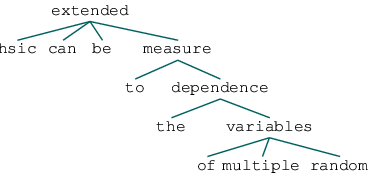

In [127]:
# Example
sent_dep = deps[50]
graph = nltk.DependencyGraph(tree_str=sent_dep)
tree = graph.tree()
print(sentences[50])
tree

** Выделим ветки деревьев **<br>
Позже можно будет использовать другие признаки, например находятся ли слова в одном поддереве

In [131]:
def get_branches(tree):
    def _get_branches(subtree, subbranches):
        subbranches *= len(subtree)
        for i, node in enumerate(subtree):
            if isinstance(node, str):
                subbranches[i] += (' ' + node)
            if isinstance(node, nltk.tree.Tree):
                subsubbranches = _get_branches(node, [subbranches[i] + ' ' + node.label()])
                del subbranches[i]
                subbranches[i:i] = subsubbranches
        return subbranches
    
    branches = [tree.label()]
    return _get_branches(tree, branches)

In [134]:
syntax_branches = []
sentences_branches_ids = []
for i, sent_dep in enumerate(deps):
    graph = nltk.DependencyGraph(tree_str=sent_dep)
    tree = graph.tree()
    subbranches = get_branches(tree)
    syntax_branches += subbranches
    sentences_branches_ids += [i] * len(subbranches)

In [155]:
syntax_branches[1123:1131]

# Example: feature datapoint

['extended hsic',
 'extended can',
 'extended be',
 'extended measure to',
 'extended measure dependence the',
 'extended measure dependence variables of',
 'extended measure dependence variables multiple',
 'extended measure dependence variables random']

<a id='topmine'></a>
# TopMine

**Загружаем лемматизированную коллекцию и стоп-слова**

In [37]:
corpora = []

for doc_id, filename in enumerate(os.listdir(LEMMATIZED_COLLECTION)):
    with open(LEMMATIZED_COLLECTION + filename, "r") as f:
        corpora.append(f.read().split(' '))

In [65]:
with open(STOPWORDS_FILE, "r") as f:
    stopwords = f.read().split('\n')
print("stopwords:\t{}".format(len(stopwords)))

stopwords:	175


**Запускаем ngrammer**

In [67]:
ng = ngrammer.NGrammer()
ng.delimiters = stopwords
ng.delimiters_regex = ['[^a-z ]+']

In [68]:
ng.frequentPhraseMining(corpora, 3)

In [69]:
ngramms = []
for document in corpora:
    res = ng.ngramm(document, threshhold=3)
    ngramms += res[0]

In [80]:
# delete points and stopwords
ngramms = [ngramm for ngramm in ngramms if (ngramm != '.') and (ngramm not in stopwords)]

In [83]:
ngramms[:10]

['supervise learn',
 'machine learning',
 'task',
 'learn',
 'function',
 'map',
 'input',
 'output',
 'base',
 'example']

**Оставим только ngramm'ы, в которых больше одного токена и они не повторяются**

In [94]:
unique_ngramms = []
for ngramm in ngramms:
    if (ngramm not in unique_ngramms) and (len(ngramm.split(' ')) > 1):
        unique_ngramms.append(ngramm)

In [106]:
unique_ngramms[47:52]
#Ngramms example

['optimization problem',
 'prior probability',
 'discriminative model',
 'special case',
 'probability distribution']

In [107]:
print("unique ngramms:\t{}".format(len(unique_ngramms)))

unique ngramms:	303


**Запишем полученные уникальные ngramm'ы в файл**

In [111]:
with open(NGRAMMS_FILE, "w") as f:
    f.write("\n".join(unique_ngramms))